In [4]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: list[Document]
    response: str


In [5]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:

# Loading

from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

ai_usage_knowledge_reources = directory_loader.load()

In [ ]:
# Loaded documents
ai_usage_knowledge_reources[0].page_content[:1000]

'NBER WORKING PAPER SERIES\nHOW PEOPLE USE CHATGPT\nAaron Chatterji\nThomas Cunningham\nDavid J. Deming\nZoe Hitzig\nChristopher Ong\nCarl Yan Shan\nKevin Wadman\nWorking Paper 34255\nhttp://www.nber.org/papers/w34255\nNATIONAL BUREAU OF ECONOMIC RESEARCH\n1050 Massachusetts Avenue\nCambridge, MA 02138\nSeptember 2025\nWe acknowledge help and comments from Joshua Achiam, Hemanth Asirvatham, Ryan \nBeiermeister, Rachel Brown, Cassandra Duchan Solis, Jason Kwon, Elliott Mokski, Kevin Rao, \nHarrison Satcher, Gawesha Weeratunga, Hannah Wong, and Analytics & Insights team. We \nespecially thank Tyna Eloundou and Pamela Mishkin who in several ways laid the foundation for \nthis work. This study was approved by Harvard IRB (IRB25-0983). A repository containing all \ncode run to produce the analyses in this paper is available on request. The views expressed herein \nare those of the authors and do not necessarily reflect the views of the National Bureau of \nEconomic Research.\nAt least one c

In [13]:
# Chunking
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken

def tiktoken_len(text):
    tokens = tiktoken.get_encoding("cl100k_base").encode(text)
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 750,
    chunk_overlap=0,
    length_function= tiktoken_len

)





In [ ]:
# Chunked documents
ai_usage_knowledge_chunks = text_splitter.split_documents(ai_usage_knowledge_reources)

In [15]:
# Vectorized the data
from langchain_ollama import OllamaEmbeddings
# System to select relevant pieces of information : embeddings
embedding_model = OllamaEmbeddings(model='embeddinggemma:latest')

In [17]:
# Dimension of the embedding

embedding_dim = len(embedding_model.embed_query("Hello"))
print(f'The dimension of embeddinggema is: {embedding_dim}')

The dimension of embeddinggema is: 768


In [ ]:
# Store in Vector Store
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(':memory:') # client

In [ ]:
client.create_collection(
    collection_name='ai_usage_knowledge',
    vectors_config= VectorParams(size=embedding_dim, distance= Distance.COSINE) #collection
)

True

In [20]:
# Vector Store
vector_store = QdrantVectorStore(
    client = client,
    collection_name = 'ai_usage_knowledge',
    embedding= embedding_model
)

In [21]:
# Add documents to the vector store

_ = vector_store.add_documents(documents=ai_usage_knowledge_chunks )

In [22]:
# retriever
retriever = vector_store.as_retriever(search_kwargs={'k':5})

In [ ]:
retriever.invoke("How do people use AI in their daily work?")

[Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data\\howpeopleuseai.pdf', 'file_path': 'data\\howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 34, '_id': 'a464e94115ff4a6dad8c506fb70d3caa', '_collection_name': 'ai_usage_knowledge'}, page_content='Panel A. Work Related\nPanel B1. Asking.\nPanel B2. Doing.\nFigure 23: (continued on next page)\n33'),
 Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data\\howpeopleuseai.pdf', 'file_path': 'data\\howpeopleuseai.pdf', 'total_pa

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 

In [44]:
# We are ready to create our nodes
def retrieve(state:State) -> State:
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

In [24]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE ="""
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know" 
"""
chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [28]:
chat_prompt.invoke({"context":"Our context here", "query":"Our query here"}).messages[0].content

'\n#CONTEXT:\nOur context here\n\nQUERY:\nOur query here\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know" \n'

In [29]:
from langchain_ollama  import ChatOllama

ollama_chat_model = ChatOllama(model='gpt-oss:20b', temperature=0.6)

In [30]:
# Call the model with a formatted prompt
ollama_chat_model.invoke(chat_prompt.invoke({"context":"Paris is the capital of France", "query":"What is the capital of France?"}))

AIMessage(content='Paris', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-09-21T10:52:10.0363249Z', 'done': True, 'done_reason': 'stop', 'total_duration': 15029862500, 'load_duration': 8769561100, 'prompt_eval_count': 133, 'prompt_eval_duration': 2877819500, 'eval_count': 49, 'eval_duration': 3354328300, 'model_name': 'gpt-oss:20b'}, id='run--6051be47-8c16-4f14-8743-9d78a3aa1a06-0', usage_metadata={'input_tokens': 133, 'output_tokens': 49, 'total_tokens': 182})

In [31]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()

generator_chain.invoke({"context":"Paris is the capital of France", "query":"What is the capital of France?"})

'Paris'

In [40]:
def generate(state:State) -> State:
    generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()
    response = generator_chain.invoke({"context":state["context"], "query":state["question"]})
    return {"response": response}

In [41]:
graph_builder = StateGraph(State) # blank canvas

In [45]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

In [ ]:
graph_builder = graph_builder.add_edge(START, "retrieve") #reference the refistered function

In [47]:
graph= graph_builder.compile()

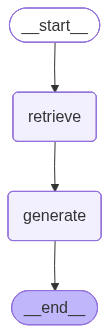

In [48]:
graph

In [49]:
# Invoke the graph as any other runnable

response = graph.invoke({"question":"How do people use AI in their daily work?"})

In [51]:
response


{'question': 'How do people use AI in their daily work?',
 'context': [Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data\\howpeopleuseai.pdf', 'file_path': 'data\\howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 34, '_id': 'a464e94115ff4a6dad8c506fb70d3caa', '_collection_name': 'ai_usage_knowledge'}, page_content='Panel A. Work Related\nPanel B1. Asking.\nPanel B2. Doing.\nFigure 23: (continued on next page)\n33'),
  Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data\\

In [52]:
response['response']

'People use AI in their everyday work mainly by **asking for help, doing tasks, and occasionally expressing ideas or emotions**.  \n- **Asking**: Workers turn to ChatGPT to get explanations, troubleshoot errors (e.g., “help fixing a Python Databricks error”), or rewrite communications (e.g., “rewrite an email to neighbors about plumbing”).\n- **Doing**: The model assists in completing work tasks—generating content, drafting code, or automating routine steps.\n- **Expressing**: This is much less common in work contexts; most work‑related interactions are focused on problem‑solving rather than emotional or expressive content.\n\nIn knowledge‑intensive roles, AI is used to boost productivity by improving the quality of decision‑making. Overall, the dominant pattern is that people use ChatGPT as a tool for information retrieval, task execution, and content creation in their daily jobs.'

In [53]:
from IPython.display import Markdown, display
display(Markdown(response['response']))

People use AI in their everyday work mainly by **asking for help, doing tasks, and occasionally expressing ideas or emotions**.  
- **Asking**: Workers turn to ChatGPT to get explanations, troubleshoot errors (e.g., “help fixing a Python Databricks error”), or rewrite communications (e.g., “rewrite an email to neighbors about plumbing”).
- **Doing**: The model assists in completing work tasks—generating content, drafting code, or automating routine steps.
- **Expressing**: This is much less common in work contexts; most work‑related interactions are focused on problem‑solving rather than emotional or expressive content.

In knowledge‑intensive roles, AI is used to boost productivity by improving the quality of decision‑making. Overall, the dominant pattern is that people use ChatGPT as a tool for information retrieval, task execution, and content creation in their daily jobs.

In [54]:
response = graph.invoke({"question":"If you had to select the main use case of AI, what would that be?"})

In [55]:
from IPython.display import Markdown, display
display(Markdown(response['response']))

Based on the excerpts, the primary use case highlighted for AI is **work‑related tasks**—whether it’s asking for help, carrying out a task, or expressing ideas in a professional context.

In [56]:
response = graph.invoke({"question": "Who is Mark Zuckerberg?"})
display(Markdown(response['response']))


I don't know.